## Crop Recommendation System With Machine Learning Algorithm 

####  Import Laibaries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import re
import pickle
warnings.filterwarnings('ignore')


#### Data Set reading and analyzing

In [2]:
crop_data = pd.read_csv('Crop and fertilizer dataset.csv')

In [3]:
# Data shape
print(crop_data.shape)
print(crop_data.head(10))

(4513, 11)
  District_Name Soil_color  Nitrogen  Phosphorus  Potassium   pH  Rainfall  \
0      Kolhapur      Black        75          50        100  6.5      1000   
1      Kolhapur      Black        80          50        100  6.5      1000   
2      Kolhapur      Black        85          50        100  6.5      1000   
3      Kolhapur      Black        90          50        100  6.5      1000   
4      Kolhapur      Black        95          50        100  6.5      1000   
5      Kolhapur      Black       100          50        100  6.5      1000   
6      Kolhapur      Black        75          55        105  7.0      1100   
7      Kolhapur      Black        80          55        105  7.0      1100   
8      Kolhapur      Black        85          55        105  7.0      1100   
9      Kolhapur      Black        90          55        105  7.0      1100   

   Temperature       Crop Fertilizer                          Link  
0           20  Sugarcane       Urea  https://youtu.be/2t5Am0

In [4]:
# Calculation of missing and duplicate values
print(f'Missing values: \n{crop_data.isna().sum()}')
print(f'Duplicate values: {crop_data.duplicated().sum()}')

Missing values: 
District_Name    0
Soil_color       0
Nitrogen         0
Phosphorus       0
Potassium        0
pH               0
Rainfall         0
Temperature      0
Crop             0
Fertilizer       0
Link             0
dtype: int64
Duplicate values: 0


In [5]:
# Drop unnecessary columns
crop_data = crop_data.drop(columns=['District_Name', 'Link'])

In [6]:
# Renameing columns to snake_case
def rename_columns(data):
    new_columns = []
    for column in data.columns:
        new_column_name = re.sub(r'(?<!^)(?=[A-Z][a-z])', '_', column).lower()
        new_columns.append(new_column_name)
    data.columns = new_columns

rename_columns(crop_data)
print(crop_data.columns)

Index(['soil_color', 'nitrogen', 'phosphorus', 'potassium', 'ph', 'rainfall',
       'temperature', 'crop', 'fertilizer'],
      dtype='object')


In [7]:
# Data types
print(crop_data.dtypes)

soil_color      object
nitrogen         int64
phosphorus       int64
potassium        int64
ph             float64
rainfall         int64
temperature      int64
crop            object
fertilizer      object
dtype: object


In [8]:
# Value counting of target variable
print(crop_data['crop'].value_counts())

crop
Sugarcane    1010
Wheat         859
Cotton        650
Jowar         394
Maize         350
Rice          309
Groundnut     177
Tur           126
Ginger        125
Grapes        125
Urad           99
Moong          99
Gram           78
Turmeric       55
Soybean        45
Masoor         12
Name: count, dtype: int64


#### Visualization of data

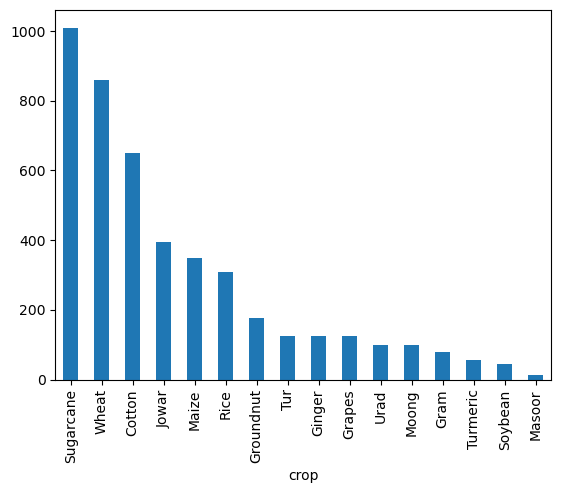

In [9]:
# Visualize target value (bar)
labels = crop_data["crop"].unique()
crop_data["crop"].value_counts().plot(kind="bar")
plt.show()

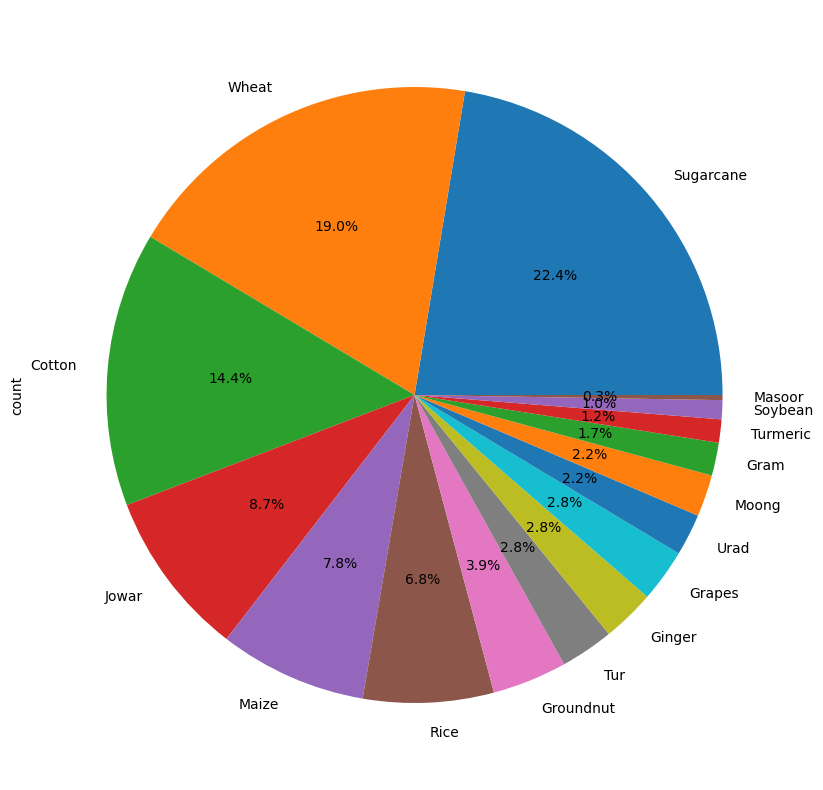

In [10]:
# Visualize target value (Pie)
plt.figure(figsize=(10,10))
crop_data['crop'].value_counts().plot(kind='pie',autopct="%.1f%%")
plt.show()

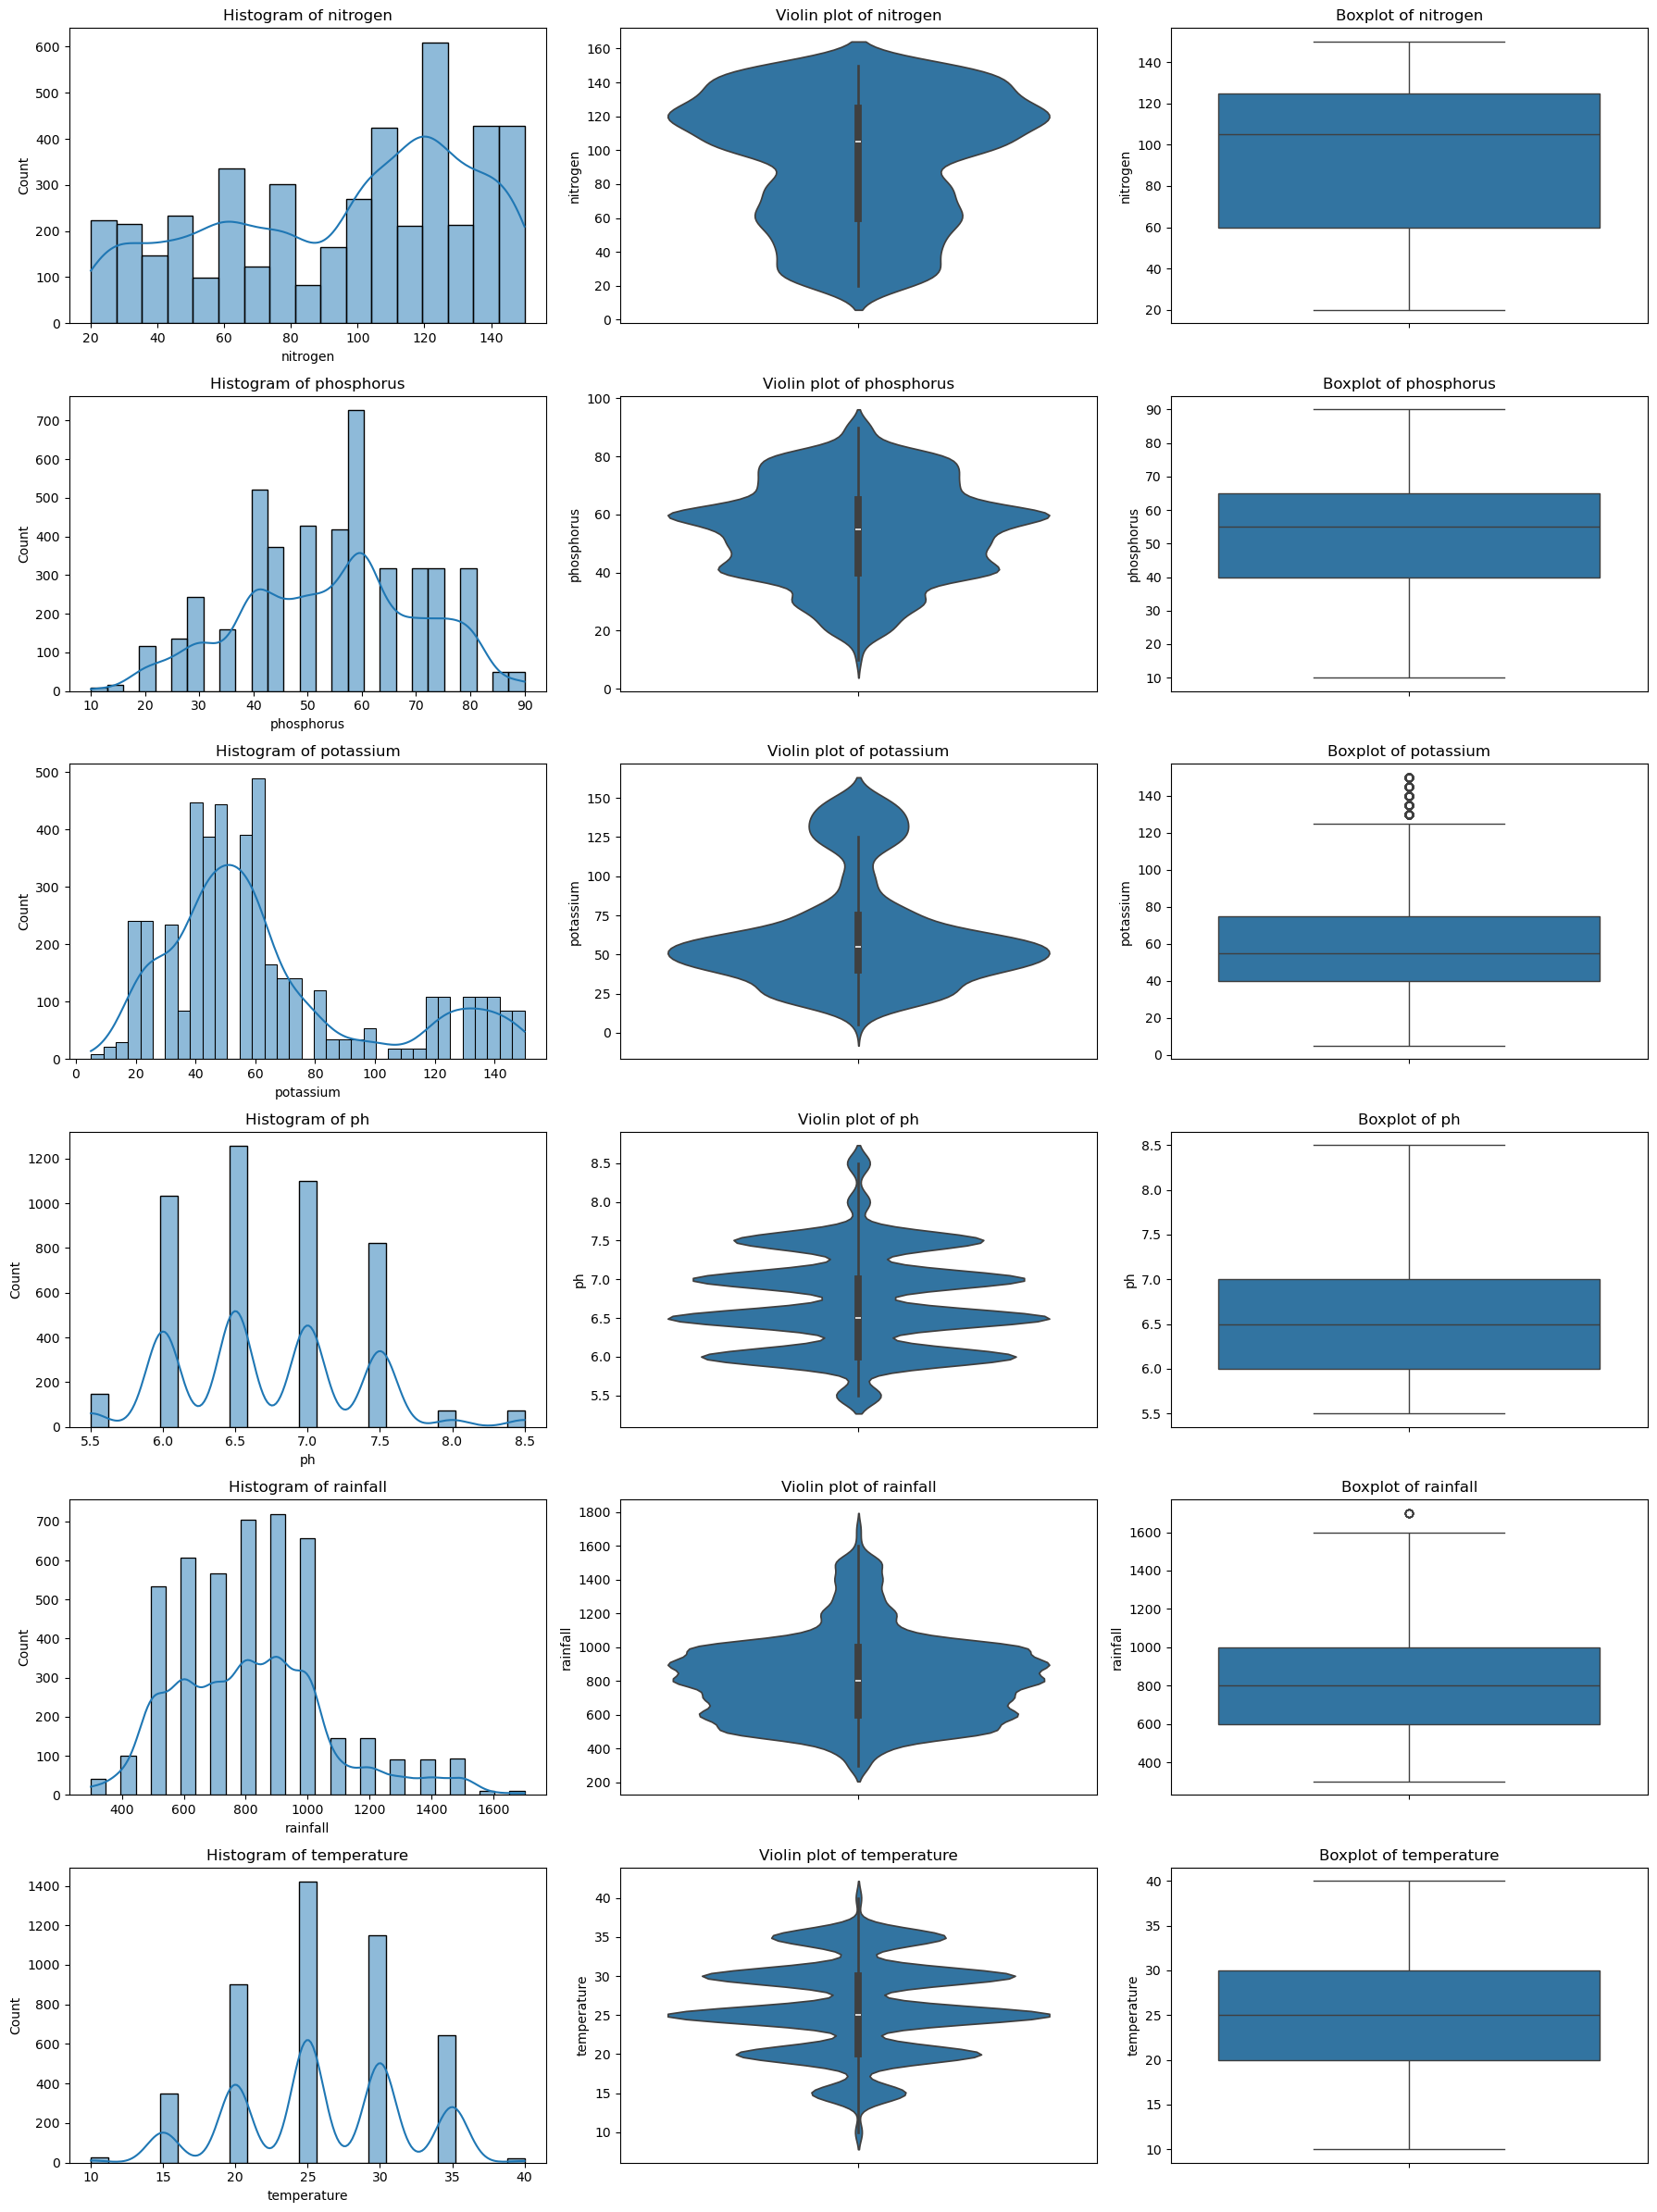

In [11]:
# distributions of numerical columns and vizualizations
numeric_columns = crop_data.select_dtypes(include='number').columns

fig, axes = plt.subplots(len(numeric_columns), 3, figsize=(18, len(numeric_columns) * 4))

for i, col in enumerate(numeric_columns):
    sns.histplot(crop_data[col], kde=True, ax=axes[i][0])
    sns.violinplot(crop_data[col], ax=axes[i][1])
    sns.boxplot(crop_data[col], ax=axes[i][2])
    axes[i][0].set_title(f'Histogram of {col}')
    axes[i][1].set_title(f'Violin plot of {col}')
    axes[i][2].set_title(f'Boxplot of {col}')

fig.tight_layout()
plt.show()


#### Data Preprocessing

In [12]:
# Mapping categorical values to numerical values
soil_color_map = {
    "Black": 1, "Red": 2, "Dark Brown": 3, "Reddish Brown": 4,
    "Light Brown": 5, "Medium Brown": 6
}

fertilizer_map = {
    "Urea": 1, "DAP": 2, "MOP": 3, "19:19:19 NPK": 4, "SSP": 5,
    "Magnesium Sulphate": 6, "10:26:26 NPK": 7, "50:26:26 NPK": 8,
    "Chelated Micronutrient": 9, "12:32:16 NPK": 10, "Ferrous Sulphate": 11,
    "13:32:26 NPK": 12, "Ammonium Sulphate": 13, "10:10:10 NPK": 14,
    "Hydrated Lime": 15, "White Potash": 16, "20:20:20 NPK": 17,
    "18:46:00 NPK": 18, "Sulphur": 19
}

crop_map = {
    "Sugarcane": 1, "Wheat": 2, "Cotton": 3, "Jowar": 4, "Maize": 5,
    "Rice": 6, "Groundnut": 7, "Tur": 8, "Grapes": 9, "Ginger": 10,
    "Urad": 11, "Moong": 12, "Gram": 13, "Turmeric": 14, "Soybean": 15,
    "Masoor": 16, "Banana": 17, "Sunflower": 18, "Pigeon Pea": 19, "Cabbage": 20
}

crop_data['soil_color'] = crop_data['soil_color'].map(soil_color_map)
crop_data['fertilizer'] = crop_data['fertilizer'].map(fertilizer_map)
crop_data['crop'] = crop_data['crop'].map(crop_map)


In [13]:
# Finding missing values after mapping
missing_values = crop_data.isnull().sum()
print(f"Missing values in each column before scaling:\n{missing_values}")

Missing values in each column before scaling:
soil_color     480
nitrogen         0
phosphorus       0
potassium        0
ph               0
rainfall         0
temperature      0
crop             0
fertilizer     108
dtype: int64


In [14]:
# Filling of missing values with mean
mode_soil_color = crop_data['soil_color'].mean()
mode_fertilizer = crop_data['fertilizer'].mean()

crop_data['soil_color'].fillna(mode_soil_color, inplace=True)
crop_data['fertilizer'].fillna(mode_fertilizer, inplace=True)

In [15]:
# Rechecking of missing values after scaling
missing_values = crop_data.isnull().sum()
print(f"Missing values in each column after scaling:\n{missing_values}")

Missing values in each column after scaling:
soil_color     0
nitrogen       0
phosphorus     0
potassium      0
ph             0
rainfall       0
temperature    0
crop           0
fertilizer     0
dtype: int64


In [16]:
# Data types
print(crop_data.dtypes)

soil_color     float64
nitrogen         int64
phosphorus       int64
potassium        int64
ph             float64
rainfall         int64
temperature      int64
crop             int64
fertilizer     float64
dtype: object


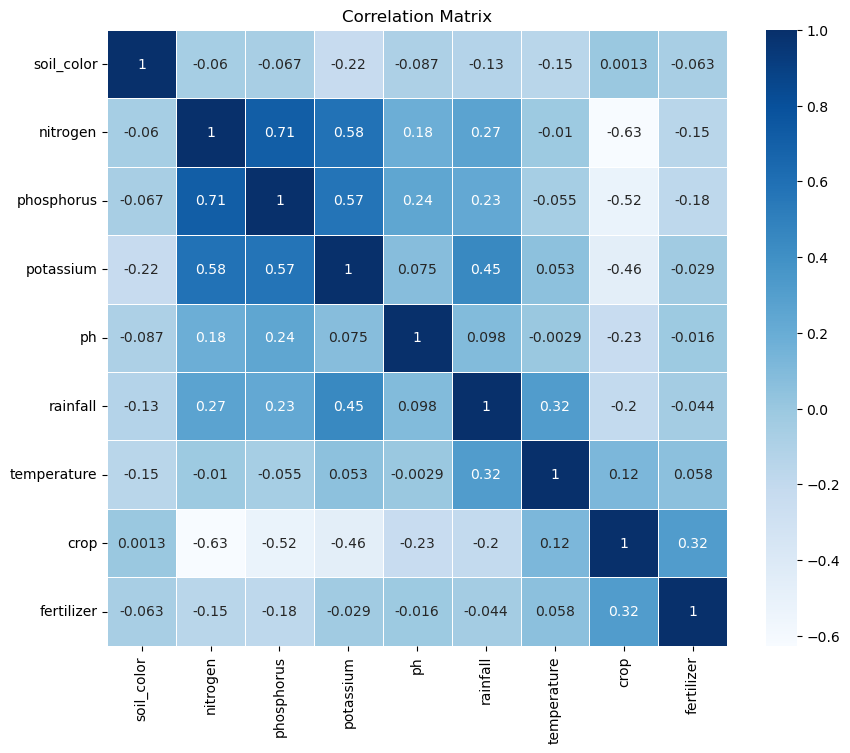

In [17]:
# correlation matrix
plt.figure(figsize=(10, 8))
corr = crop_data.corr()
sns.heatmap(corr, annot=True, cmap='Blues', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [18]:
# Outlier Detection With IQR Technique
numerical_columns = crop_data.select_dtypes(include=[np.number]).columns
def find_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

outliers_dict = {}
for col in numerical_columns:
    outliers = find_outliers(crop_data, col)
    outliers_dict[col] = outliers
    print(f'Number of outliers in {col}: {len(outliers)}')



Number of outliers in soil_color: 370
Number of outliers in nitrogen: 0
Number of outliers in phosphorus: 0
Number of outliers in potassium: 495
Number of outliers in ph: 0
Number of outliers in rainfall: 9
Number of outliers in temperature: 0
Number of outliers in crop: 190
Number of outliers in fertilizer: 237


In [19]:
# Remove outliers using IQR method
for col in numeric_columns:
    Q1 = crop_data[col].quantile(0.25)
    Q3 = crop_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    crop_data = crop_data[(crop_data[col] >= lower_bound) & (crop_data[col] <= upper_bound)]

print(f'Dataset shape after removing outliers: {crop_data.shape}')

Dataset shape after removing outliers: (3873, 9)


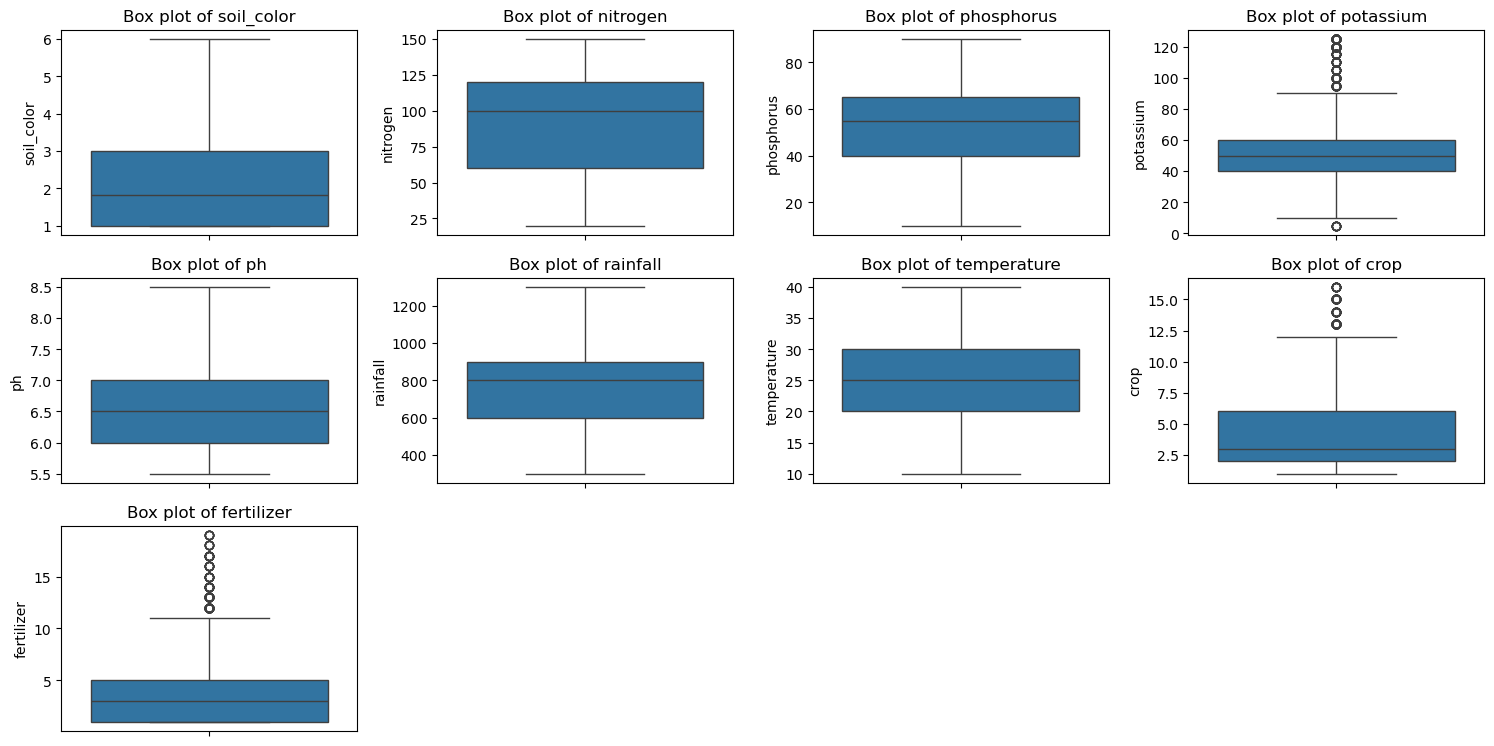

In [20]:
# Vizualization after removing outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=crop_data[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()


Counts of target classes:
crop
2     859
3     650
1     545
4     394
5     350
6     237
7     177
8     126
10    125
11     99
12     99
13     78
9      50
15     45
14     27
16     12
Name: count, dtype: int64

Percentage distribution of target classes:
crop
2     22.179189
3     16.782856
1     14.071779
4     10.172993
5      9.036922
6      6.119287
7      4.570101
8      3.253292
10     3.227472
11     2.556158
12     2.556158
13     2.013943
9      1.290989
15     1.161890
14     0.697134
16     0.309837
Name: proportion, dtype: float64


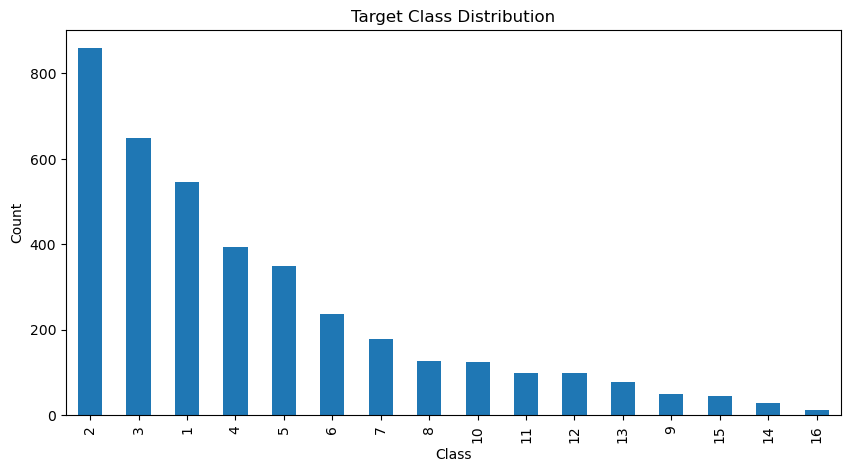

In [21]:
# Target class distribution and data type
target_counts = crop_data['crop'].value_counts()
target_percentage = crop_data['crop'].value_counts(normalize=True) * 100

print("Counts of target classes:")
print(target_counts)

print("\nPercentage distribution of target classes:")
print(target_percentage)

plt.figure(figsize=(10, 5))
target_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Target Class Distribution')
plt.show()

#### Data Preparation

In [22]:
X = crop_data.drop('crop', axis=1)  # Features
y = crop_data['crop']  # Target variable (crop)

In [23]:
# Using Standard Scaler to scale the target class
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# Handle imbalanced useing SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [25]:
print(f"Outcome class size before SMOTE: {y.value_counts()}")
print(f"Outcome class size after SMOTE: {y_resampled.value_counts()}")

Outcome class size before SMOTE: crop
2     859
3     650
1     545
4     394
5     350
6     237
7     177
8     126
10    125
11     99
12     99
13     78
9      50
15     45
14     27
16     12
Name: count, dtype: int64
Outcome class size after SMOTE: crop
1     859
4     859
3     859
6     859
2     859
7     859
5     859
8     859
11    859
12    859
13    859
16    859
15    859
10    859
14    859
9     859
Name: count, dtype: int64


In [26]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of testing label:', y_test.shape)

Shape of training feature: (10995, 8)
Shape of testing feature: (2749, 8)
Shape of training label: (10995,)
Shape of testing label: (2749,)


### Model Building

#### DecisionTree Classifier

In [27]:
# DecisionTree Perameter tuning
param_grid_dt = {
    'criterion': ['gini'], 
    'max_depth': [6, 8],  
    'min_samples_split': [30, 40],  
    'min_samples_leaf': [20, 30] 
}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, n_jobs=-1, scoring='accuracy')
grid_dt.fit(X_train, y_train)

best_dt_model = grid_dt.best_estimator_
y_train_pred = best_dt_model.predict(X_train)
y_test_pred = best_dt_model.predict(X_test)

In [28]:
# Compute confusion matrices for training and testing datasets
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

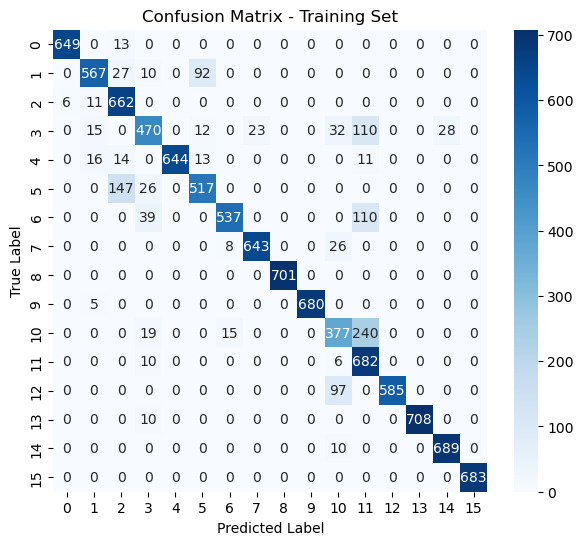

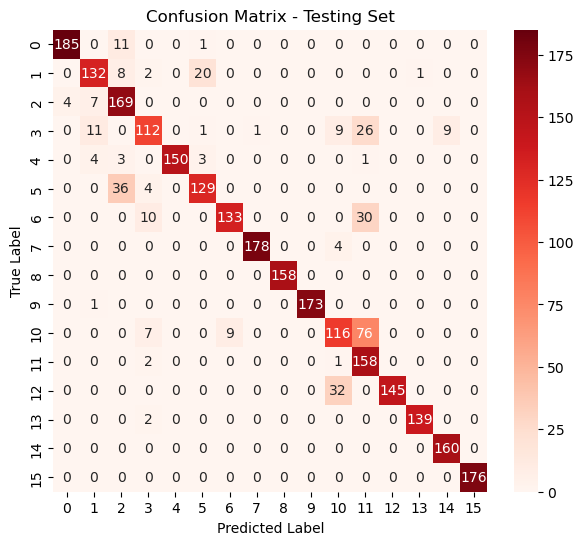

In [29]:
# Plotting Confusion Matrix for the Training Set
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting Confusion Matrix for the Testing Set
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - Testing Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [30]:
# Calculate probabilities for ROC curves
y_train_prob = best_dt_model.predict_proba(X_train)[:, 1]
y_test_prob = best_dt_model.predict_proba(X_test)[:, 1]

In [31]:
# Calculate metrics for the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')

In [32]:
# Calculate metrics for the best model on the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

In [33]:
# Calculate metrics for the best model on the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

In [34]:
# Print metrics
print(f'Best Parameters: {grid_dt.best_params_}')
print(f'Training Accuracy: {accuracy_train:.2f}')
print(f'Test Accuracy: {accuracy_test:.2f}')
print(f'Training Precision: {precision_train:.2f}')
print(f'Test Precision: {precision_test:.2f}')
print(f'Training Recall: {recall_train:.2f}')
print(f'Test Recall: {recall_test:.2f}')
print(f'Training F1 Score: {f1_train:.2f}')
print(f'Test F1 Score: {f1_test:.2f}')

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 30}
Training Accuracy: 0.89
Test Accuracy: 0.88
Training Precision: 0.90
Test Precision: 0.89
Training Recall: 0.89
Test Recall: 0.88
Training F1 Score: 0.89
Test F1 Score: 0.88


In [35]:
# ROC Curve initialization
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
classes = best_dt_model.classes_

# Binarize the output
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Calculate probabilities for ROC curves
y_train_prob = best_dt_model.predict_proba(X_train)
y_test_prob = best_dt_model.predict_proba(X_test)

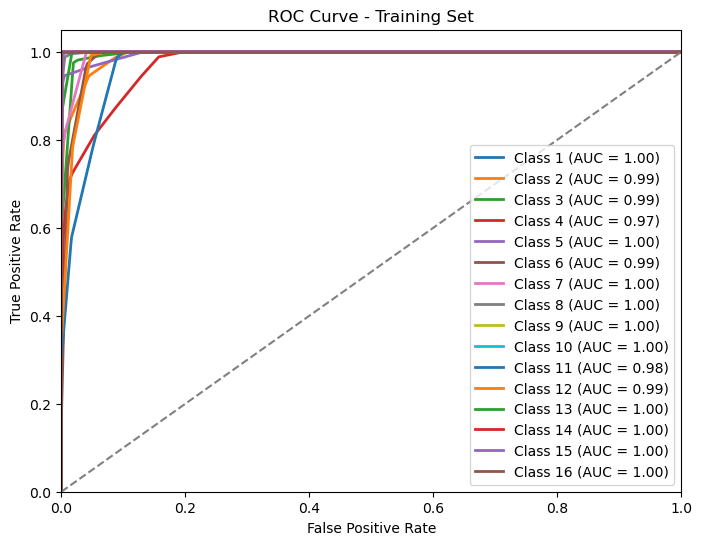

In [36]:
# Plotting the ROC Curve for the Training set
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_prob[:, i])
    roc_auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc_train:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc="lower right")
plt.show()

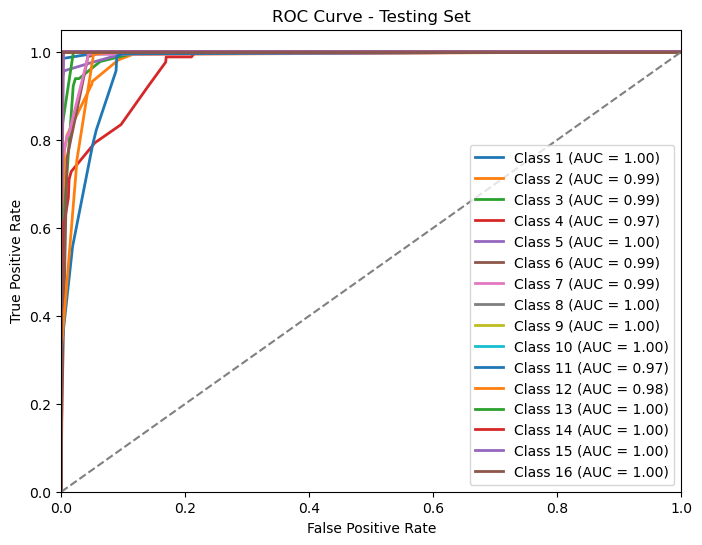

In [37]:
# Plotting the ROC Curve for the Testing set
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc_test:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Testing Set')
plt.legend(loc="lower right")
plt.show()

In [38]:
# Define metrics for the training set
metrics_train = {
    'Accuracy': accuracy_train,
    'Precision': precision_train,
    'Recall': recall_train,
    'F1 Score': f1_train
}

# Define metrics for the testing set
metrics_test = {
    'Accuracy': accuracy_test,
    'Precision': precision_test,
    'Recall': recall_test,
    'F1 Score': f1_test
}

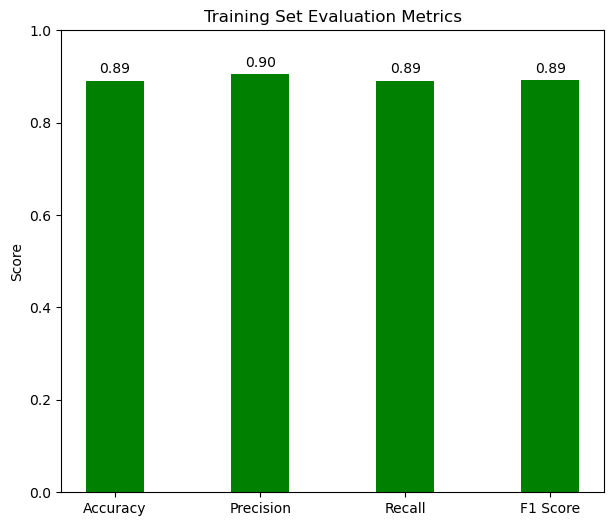

In [39]:
# Plotting Training Set Evaluation Metrics
plt.figure(figsize=(7, 6))
bars = plt.bar(metrics_train.keys(), metrics_train.values(), color='green', width=0.4)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Training Set Evaluation Metrics')

# Annotating each bar with its corresponding value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

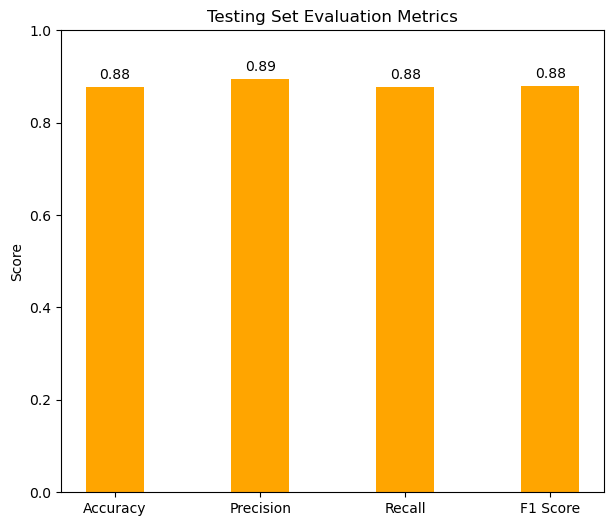

In [40]:
# Plotting Testing Set Evaluation Metrics
plt.figure(figsize=(7, 6))
bars = plt.bar(metrics_test.keys(), metrics_test.values(), color='orange', width=0.4)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Testing Set Evaluation Metrics')

# Annotating each bar with its corresponding value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

#### RandomForest 

In [41]:
# Random forest Classifier perameter defining
param_grid_rf = {
    'n_estimators': [100, 200],  
    'max_depth': [6, 8],  
    'min_samples_split': [30, 40],  
    'min_samples_leaf': [20, 30], 
    'criterion': ['gini'],  
}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy')
grid_rf.fit(X_train, y_train)

best_rf_model = grid_rf.best_estimator_
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

In [42]:
# confusion matrix for the training and test set predictions
conf_matrix_train = confusion_matrix(y_train, y_train_pred_rf)
conf_matrix_test = confusion_matrix(y_test, y_test_pred_rf)

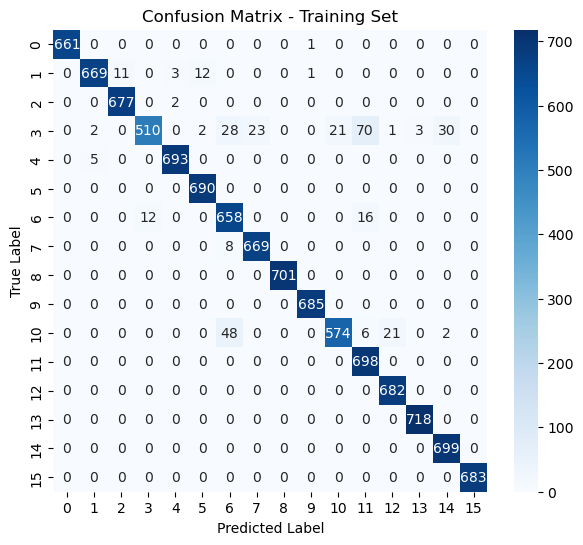

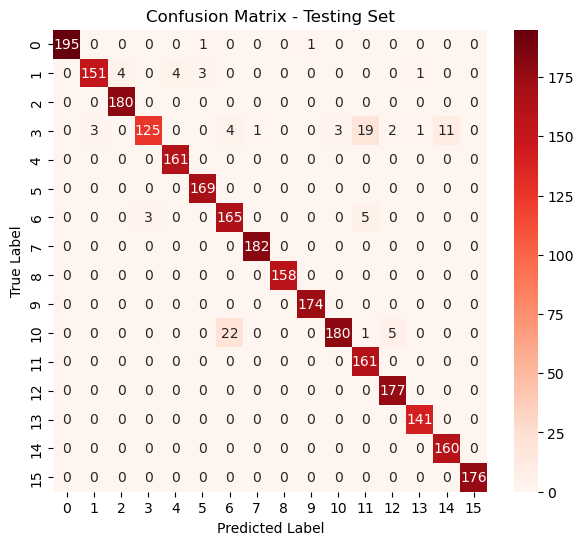

In [43]:
# Plotting Confusion Matrix for the Training Set
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting Confusion Matrix for the Testing Set
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - Testing Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
# Calculate probabilities for ROC curves
y_train_prob_rf = best_rf_model.predict_proba(X_train)[:, 1]
y_test_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]

In [45]:
# Calculate metrics for the best model on the test set
accuracy_test_rf = accuracy_score(y_test, y_test_pred_rf)
precision_test_rf = precision_score(y_test, y_test_pred_rf, average='weighted')
recall_test_rf = recall_score(y_test, y_test_pred_rf, average='weighted')
f1_test_rf = f1_score(y_test, y_test_pred_rf, average='weighted')

In [46]:
# Calculate metrics for the best model on the training set
accuracy_train_rf = accuracy_score(y_train, y_train_pred_rf)
precision_train_rf = precision_score(y_train, y_train_pred_rf, average='weighted')
recall_train_rf = recall_score(y_train, y_train_pred_rf, average='weighted')
f1_train_rf = f1_score(y_train, y_train_pred_rf, average='weighted')

In [47]:
# Print metrics
print(f'Best Parameters: {grid_rf.best_params_}')
print(f'Training Accuracy: {accuracy_train_rf:.2f}')
print(f'Test Accuracy: {accuracy_test_rf:.2f}')
print(f'Training Precision: {precision_train_rf:.2f}')
print(f'Test Precision: {precision_test_rf:.2f}')
print(f'Training Recall: {recall_train_rf:.2f}')
print(f'Test Recall: {recall_test_rf:.2f}')
print(f'Training F1 Score: {f1_train_rf:.2f}')
print(f'Test F1 Score: {f1_test_rf:.2f}')

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 30, 'n_estimators': 100}
Training Accuracy: 0.97
Test Accuracy: 0.97
Training Precision: 0.97
Test Precision: 0.97
Training Recall: 0.97
Test Recall: 0.97
Training F1 Score: 0.97
Test F1 Score: 0.96


In [48]:
# Assuming y_train and y_test are your true labels
classes = best_dt_model.classes_

# Binarize the output
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Calculate probabilities for ROC curves
y_train_prob = best_dt_model.predict_proba(X_train)
y_test_prob = best_dt_model.predict_proba(X_test)

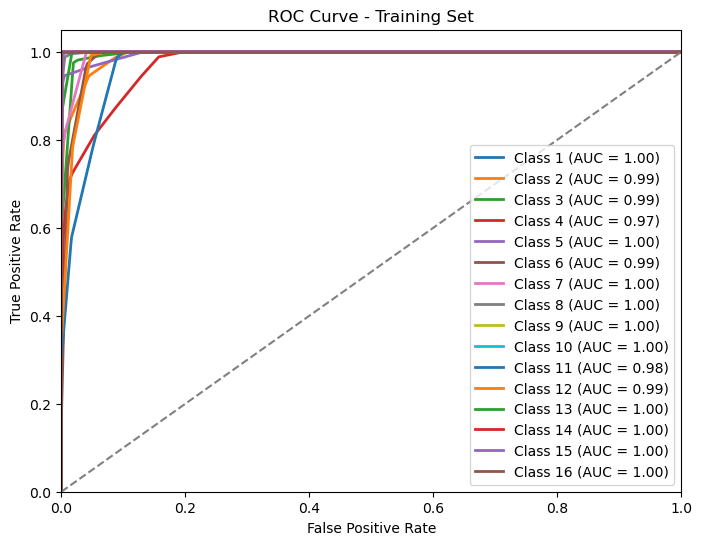

In [49]:
# Plotting the ROC Curve for the Training set
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_prob[:, i])
    roc_auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc_train:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc="lower right")
plt.show()

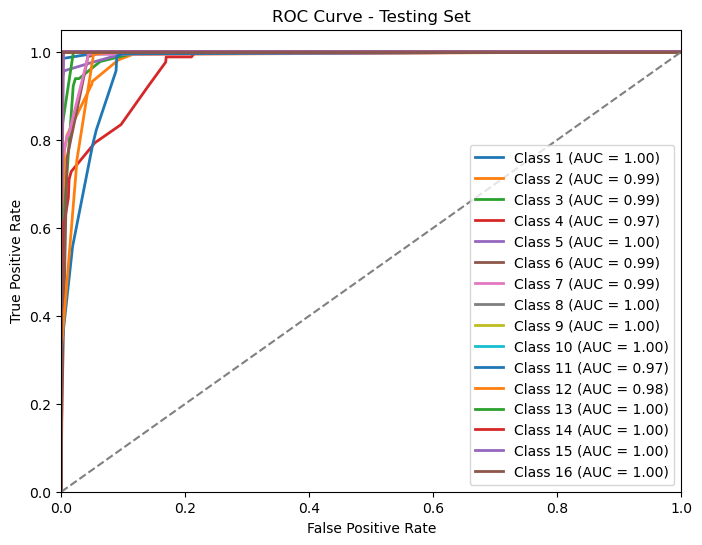

In [50]:
# Plotting the ROC Curve for the Testing set
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc_test:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Testing Set')
plt.legend(loc="lower right")
plt.show()

In [51]:
# Define metrics for the training set
metrics_train = {
    'Accuracy': accuracy_train,
    'Precision': precision_train,
    'Recall': recall_train,
    'F1 Score': f1_train
}

In [52]:
# Define metrics for the testing set
metrics_test = {
    'Accuracy': accuracy_test,
    'Precision': precision_test,
    'Recall': recall_test,
    'F1 Score': f1_test
}

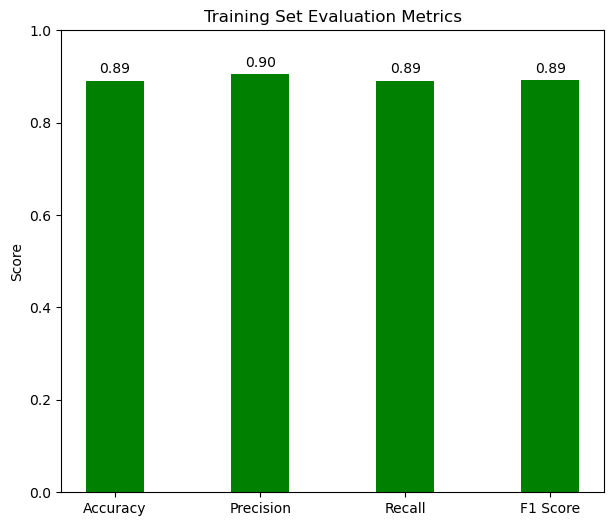

In [53]:
# Plotting Training Set Evaluation Metrics
plt.figure(figsize=(7, 6))
bars = plt.bar(metrics_train.keys(), metrics_train.values(), color='green', width=0.4)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Training Set Evaluation Metrics')

# Annotating each bar with its corresponding value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

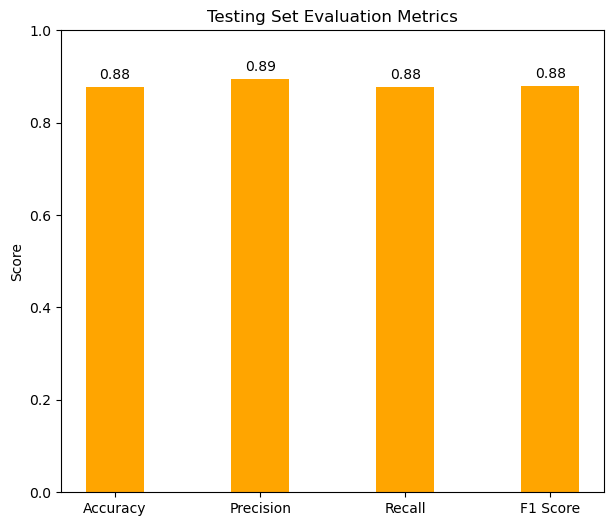

In [54]:
# Plotting Testing Set Evaluation Metrics
plt.figure(figsize=(7, 6))
bars = plt.bar(metrics_test.keys(), metrics_test.values(), color='orange', width=0.4)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Testing Set Evaluation Metrics')

# Annotating each bar with its corresponding value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

### SVM Classification

In [55]:

# SVM perameter
param_grid_svm = {
    'C': [0.01, 0.1, 1],  
    'kernel': ['linear'],  
    'gamma': ['scale']   
}
svm = SVC(probability=True)
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)
best_svm_model = grid_search_svm.best_estimator_
y_train_pred_svm = best_svm_model.predict(X_train)
y_test_pred_svm = best_svm_model.predict(X_test)


In [56]:
# Calculate metrics for the best model on the test set
accuracy_test_svm = accuracy_score(y_test, y_test_pred_svm)
precision_test_svm = precision_score(y_test, y_test_pred_svm, average='weighted')
recall_test_svm = recall_score(y_test, y_test_pred_svm, average='weighted')
f1_test_svm = f1_score(y_test, y_test_pred_svm, average='weighted')

In [57]:
# Calculate metrics for the best model on the training set
accuracy_train_svm = accuracy_score(y_train, y_train_pred_svm)
precision_train_svm = precision_score(y_train, y_train_pred_svm, average='weighted')
recall_train_svm = recall_score(y_train, y_train_pred_svm, average='weighted')
f1_train_svm = f1_score(y_train, y_train_pred_svm, average='weighted')

In [58]:
# Print metrics
print(f'Best Parameters: {grid_search_svm.best_params_}')
print(f'Training Accuracy: {accuracy_train_svm:.2f}')
print(f'Test Accuracy: {accuracy_test_svm:.2f}')
print(f'Training Precision: {precision_train_svm:.2f}')
print(f'Test Precision: {precision_test_svm:.2f}')
print(f'Training Recall: {recall_train_svm:.2f}')
print(f'Test Recall: {recall_test_svm:.2f}')
print(f'Training F1 Score: {f1_train_svm:.2f}')
print(f'Test F1 Score: {f1_test_svm:.2f}')

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Training Accuracy: 0.91
Test Accuracy: 0.90
Training Precision: 0.91
Test Precision: 0.90
Training Recall: 0.91
Test Recall: 0.90
Training F1 Score: 0.91
Test F1 Score: 0.90


In [59]:
# Assuming y_train and y_test are your true labels
classes = best_svm_model.classes_

# Binarize the output
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Calculate probabilities for ROC curves
y_train_prob = best_rf_model.predict_proba(X_train)
y_test_prob = best_rf_model.predict_proba(X_test)

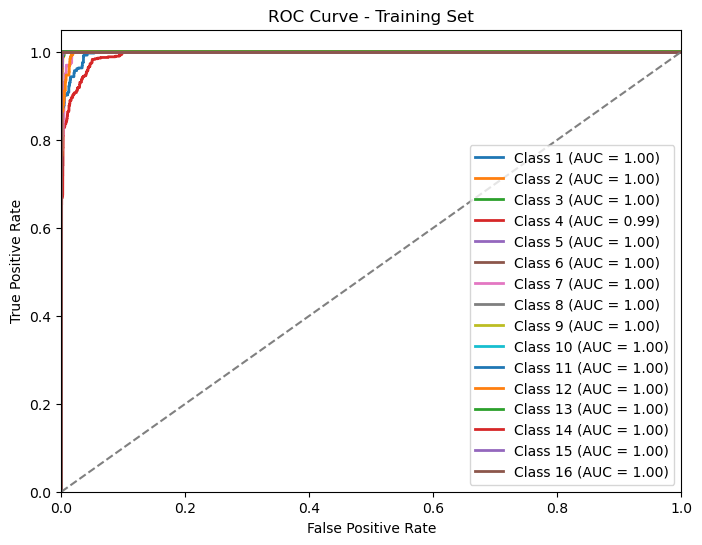

In [60]:
# Plotting the ROC Curve for the Training set
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_prob[:, i])
    roc_auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc_train:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc="lower right")
plt.show()

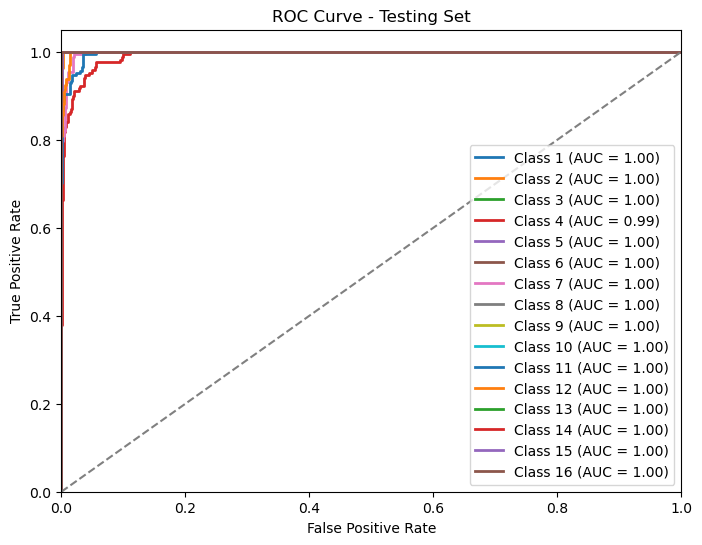

In [61]:
# Plotting the ROC Curve for the Testing set
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc_test:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Testing Set')
plt.legend(loc="lower right")
plt.show()

In [62]:
# Define metrics for the training set using RandomForest model
metrics_train_svm = {
    'Accuracy': accuracy_train_svm,
    'Precision': precision_train_svm,
    'Recall': recall_train_svm,
    'F1 Score': f1_train_svm
}

In [63]:
# Define metrics for the testing set using RandomForest model
metrics_test_svm = {
    'Accuracy': accuracy_test_svm,
    'Precision': precision_test_svm,
    'Recall': recall_test_svm,
    'F1 Score': f1_test_svm
}

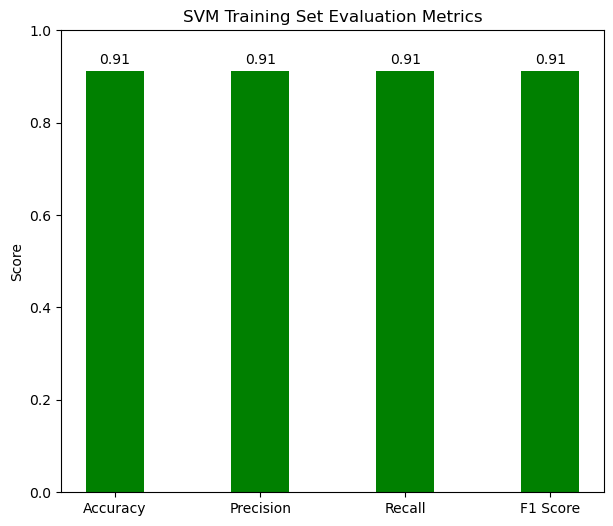

In [64]:
# Plotting Training Set Evaluation Metrics for RandomForest
plt.figure(figsize=(7, 6))
bars = plt.bar(metrics_train_svm.keys(), metrics_train_svm.values(), color='green', width=0.4)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('SVM Training Set Evaluation Metrics')

# Annotating each bar with its corresponding value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

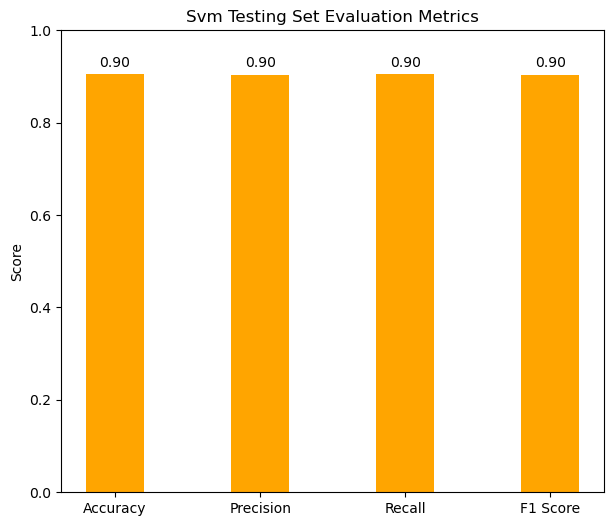

In [65]:
# Plotting Testing Set Evaluation Metrics for RandomForest
plt.figure(figsize=(7, 6))
bars = plt.bar(metrics_test_svm.keys(), metrics_test_svm.values(), color='orange', width=0.4)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Svm Testing Set Evaluation Metrics')

# Annotating each bar with its corresponding value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

In [66]:
# Generate the confusion matrix for the training and test set predictions
conf_matrix_train = confusion_matrix(y_train, y_train_pred_svm)
conf_matrix_test = confusion_matrix(y_test, y_test_pred_svm)

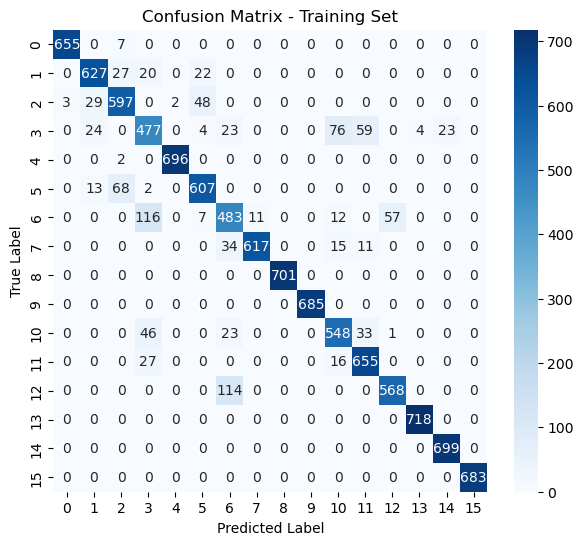

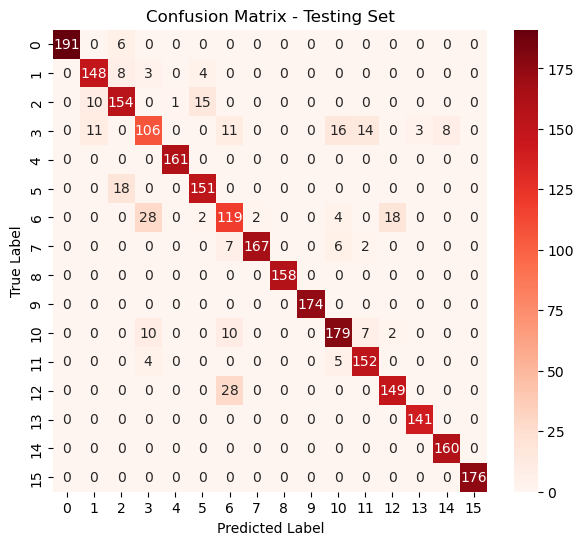

In [67]:
# Plotting Confusion Matrix for the Training Set
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting Confusion Matrix for the Testing Set
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - Testing Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Logistic Regression Classification

In [68]:
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  
    'solver': ['liblinear', 'saga']  
}
logreg = LogisticRegression(max_iter=1000) 
grid_search_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)
best_logreg_model = grid_search_logreg.best_estimator_
y_train_pred_logreg = best_logreg_model.predict(X_train)
y_test_pred_logreg = best_logreg_model.predict(X_test)


In [69]:
# Calculate metrics for the best model on the test set
accuracy_test_logreg = accuracy_score(y_test, y_test_pred_logreg)
precision_test_logreg = precision_score(y_test, y_test_pred_logreg, average='weighted')
recall_test_logreg = recall_score(y_test, y_test_pred_logreg, average='weighted')
f1_test_logreg = f1_score(y_test, y_test_pred_logreg, average='weighted')

In [70]:
# Calculate metrics for the best model on the training set
accuracy_train_logreg = accuracy_score(y_train, y_train_pred_logreg)
precision_train_logreg = precision_score(y_train, y_train_pred_logreg, average='weighted')
recall_train_logreg = recall_score(y_train, y_train_pred_logreg, average='weighted')
f1_train_logreg = f1_score(y_train, y_train_pred_logreg, average='weighted')

In [71]:
# Print metrics
print(f'Best Parameters: {grid_search_logreg.best_params_}')
print(f'Training Accuracy: {accuracy_train_logreg:.2f}')
print(f'Test Accuracy: {accuracy_test_logreg:.2f}')
print(f'Training Precision: {precision_train_logreg:.2f}')
print(f'Test Precision: {precision_test_logreg:.2f}')
print(f'Training Recall: {recall_train_logreg:.2f}')
print(f'Test Recall: {recall_test_logreg:.2f}')
print(f'Training F1 Score: {f1_train_logreg:.2f}')
print(f'Test F1 Score: {f1_test_logreg:.2f}')

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Training Accuracy: 0.85
Test Accuracy: 0.83
Training Precision: 0.84
Test Precision: 0.83
Training Recall: 0.85
Test Recall: 0.83
Training F1 Score: 0.84
Test F1 Score: 0.83


In [72]:

# Assuming y_train and y_test are your true labels
classes = best_logreg_model.classes_

# Binarize the output
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Calculate probabilities for ROC curves
y_train_prob = best_logreg_model.predict_proba(X_train)
y_test_prob = best_logreg_model.predict_proba(X_test)

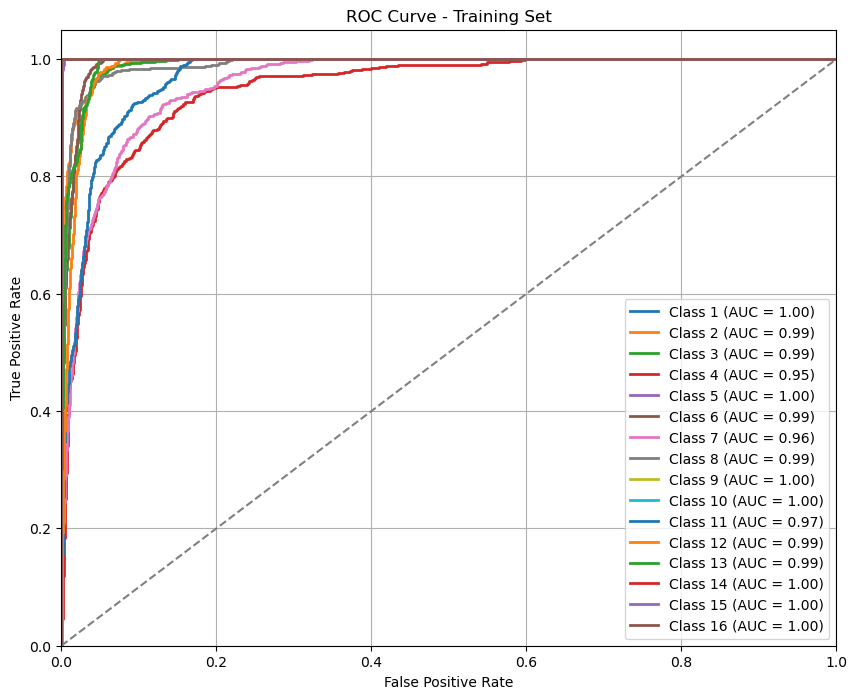

In [73]:
# Plotting the ROC Curve for the Training set
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_prob[:, i])
    roc_auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc_train:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc="lower right")
plt.grid()
plt.show()

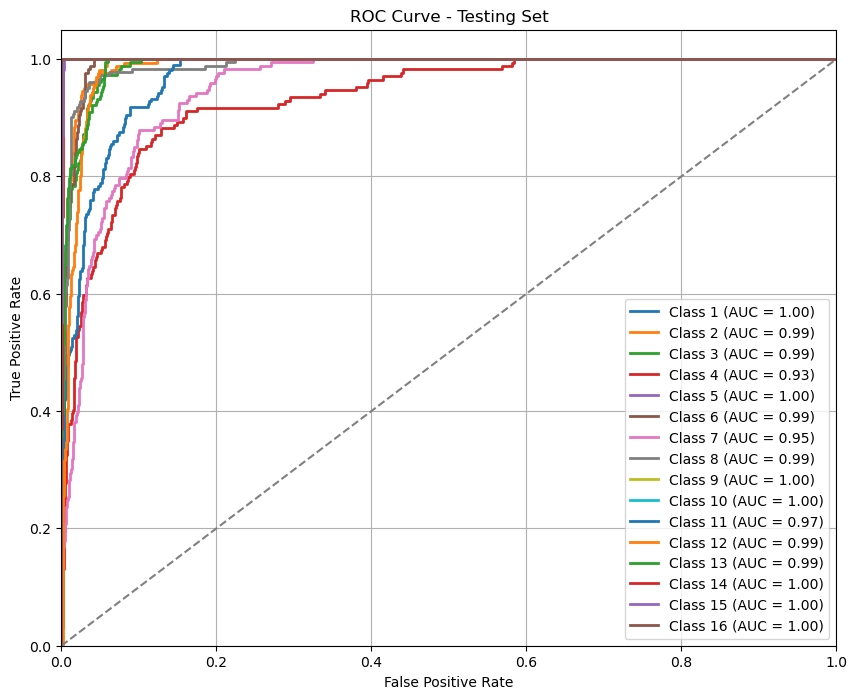

In [74]:

# Plotting the ROC Curve for the Testing set
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc_test:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Testing Set')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [75]:
# Define metrics for the training set using RandomForest model
metrics_train_lr = {
    'Accuracy': accuracy_train_logreg,
    'Precision': precision_train_logreg,
    'Recall': recall_train_logreg,
    'F1 Score': f1_train_logreg
}

# Define metrics for the testing set using RandomForest model
metrics_test_lr = {
    'Accuracy': accuracy_test_logreg,
    'Precision': precision_test_logreg,
    'Recall': recall_test_logreg,
    'F1 Score': f1_test_logreg
}

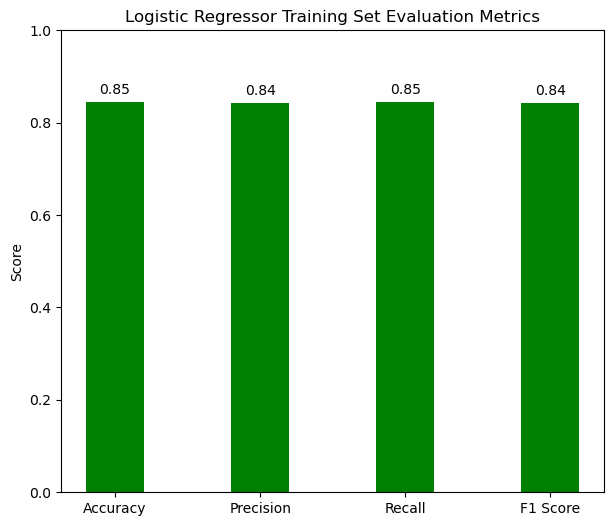

In [76]:
# Plotting Training Set Evaluation Metrics for RandomForest
plt.figure(figsize=(7, 6))
bars = plt.bar(metrics_train_lr.keys(), metrics_train_lr.values(), color='green', width=0.4)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Logistic Regressor Training Set Evaluation Metrics')

# Annotating each bar with its corresponding value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

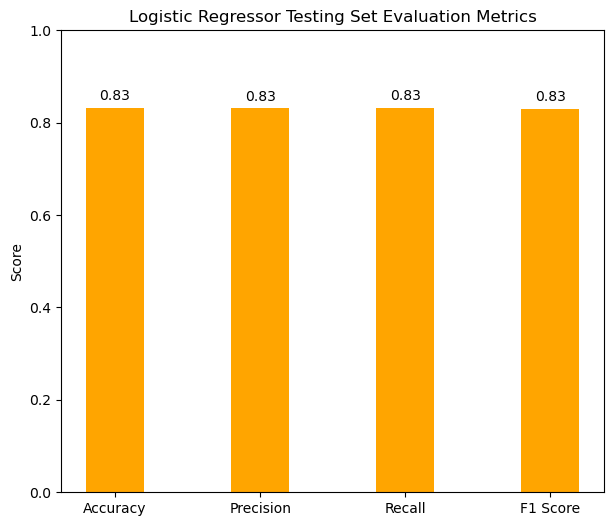

In [77]:
# Plotting Testing Set Evaluation Metrics for RandomForest
plt.figure(figsize=(7, 6))
bars = plt.bar(metrics_test_lr.keys(), metrics_test_lr.values(), color='orange', width=0.4)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title( 'Logistic Regressor Testing Set Evaluation Metrics')

# Annotating each bar with its corresponding value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

In [78]:
# Generate the confusion matrix for the training and test set predictions
conf_matrix_train = confusion_matrix(y_train, y_train_pred_logreg)
conf_matrix_test = confusion_matrix(y_test, y_test_pred_logreg)

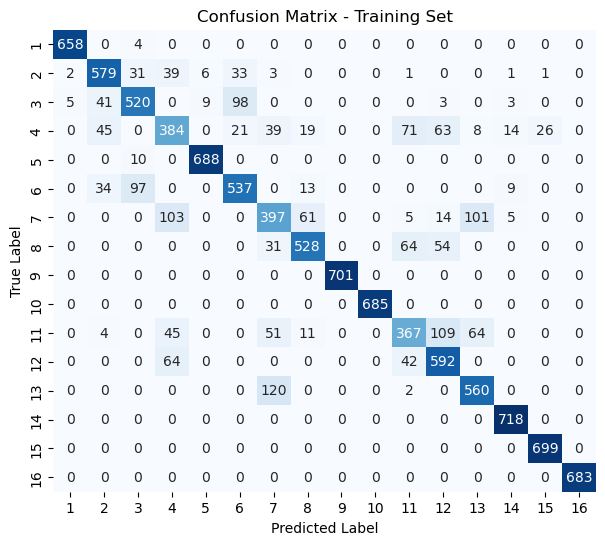

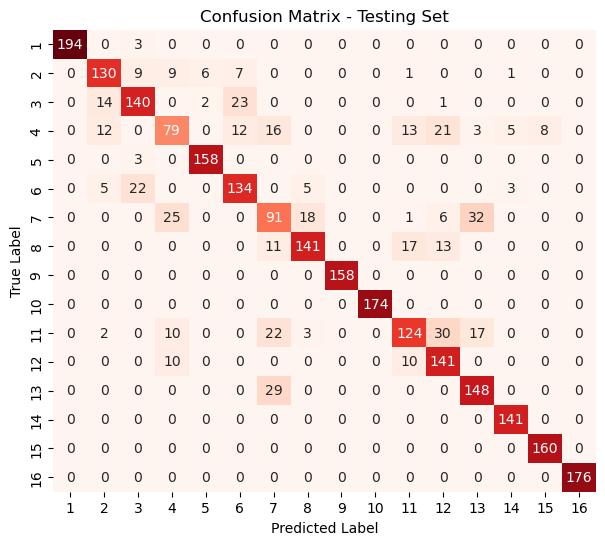

In [79]:
# Plotting Confusion Matrix for the Training Set
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting Confusion Matrix for the Testing Set
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Testing Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Model Comparison and Plotting 

In [80]:
# model names
models = ['Decision Tree', 'Random Forest', 'SVM', 'Logistic Regression']

# metrics for training and testing sets
train_accuracies = [accuracy_train, accuracy_train_rf, accuracy_train_svm, accuracy_train_logreg]
test_accuracies = [accuracy_test, accuracy_test_rf, accuracy_test_svm, accuracy_test_logreg]

train_precisions = [precision_train, precision_train_rf, precision_train_svm, precision_train_logreg]
test_precisions = [precision_test, precision_test_rf, precision_test_svm, precision_test_logreg]

train_recalls = [recall_train, recall_train_rf, recall_train_svm, recall_train_logreg]
test_recalls = [recall_test, recall_test_rf, recall_test_svm, recall_test_logreg]

train_f1_scores = [f1_train, f1_train_rf, f1_train_svm, f1_train_logreg]
test_f1_scores = [f1_test, f1_test_rf, f1_test_svm, f1_test_logreg]

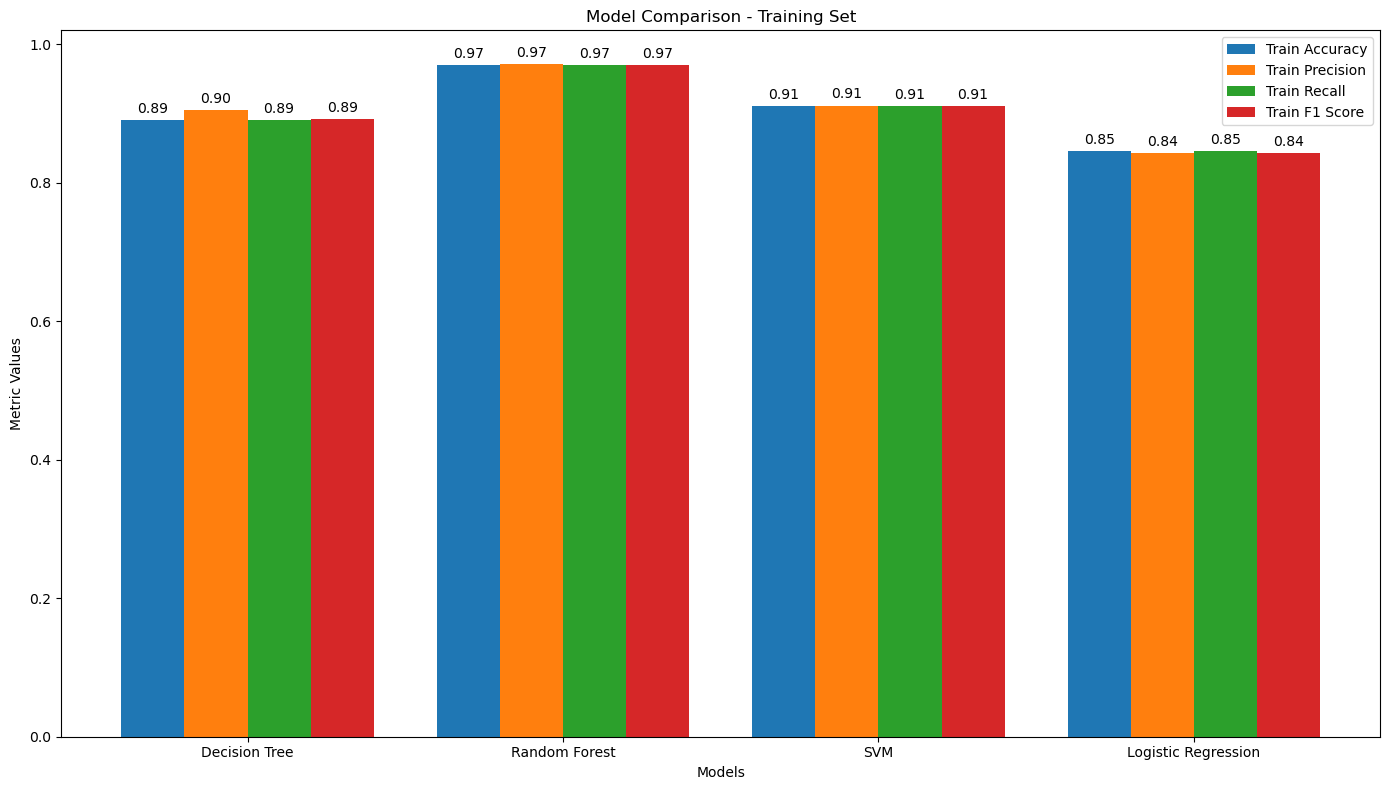

In [81]:
# Define positions for the bars
x = np.arange(len(models))  
width = 0.2  

# Define colors for the bars
colors_train = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  
colors_test = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']   

# Plotting Training Metrics
fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width * 1.5, train_accuracies, width, color=colors_train[0], label='Train Accuracy')
bars2 = ax.bar(x - width * 0.5, train_precisions, width, color=colors_train[1], label='Train Precision')
bars3 = ax.bar(x + width * 0.5, train_recalls, width, color=colors_train[2], label='Train Recall')
bars4 = ax.bar(x + width * 1.5, train_f1_scores, width, color=colors_train[3], label='Train F1 Score')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Metric Values')
ax.set_title('Model Comparison - Training Set')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adding value labels on the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)

plt.tight_layout()
plt.show()

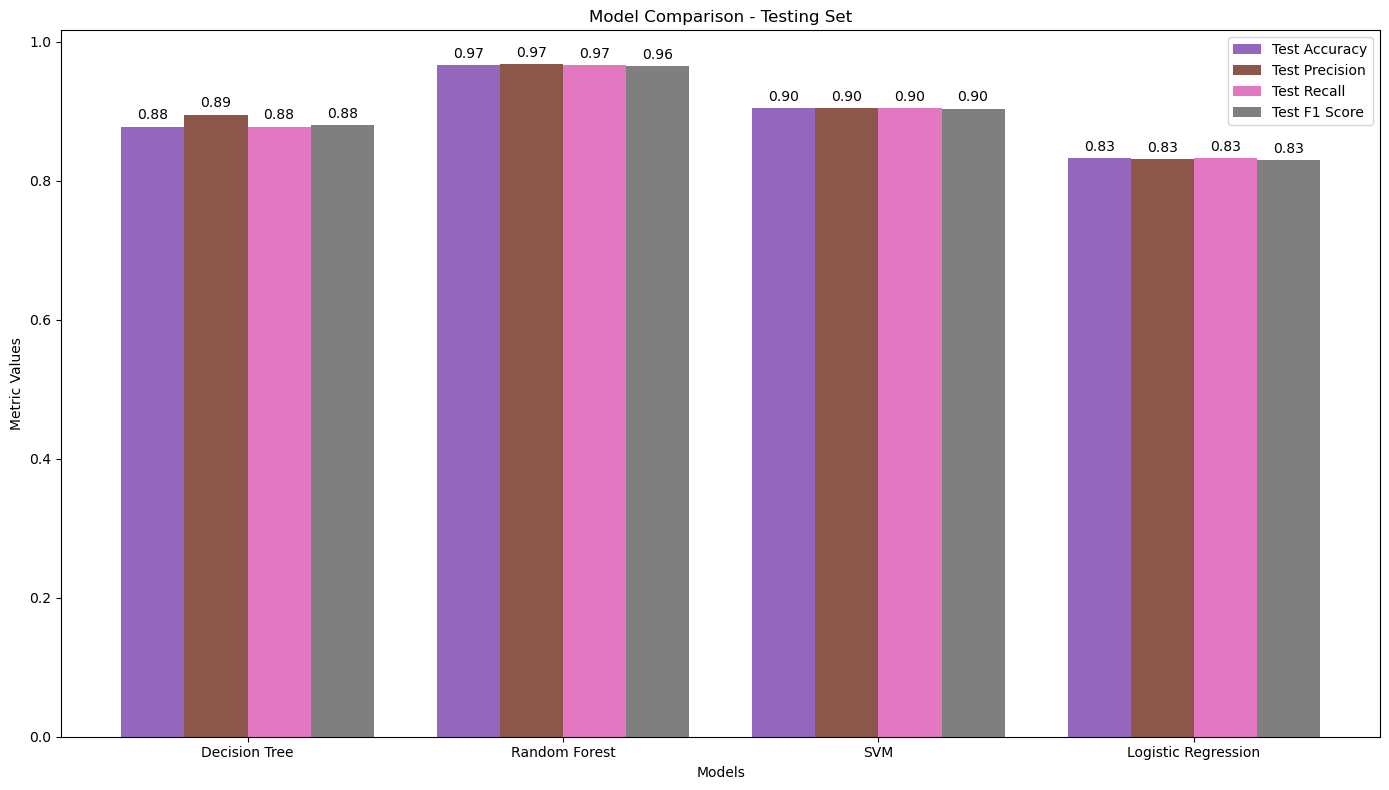

In [82]:
# Plotting Testing Metrics
fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width * 1.5, test_accuracies, width, color=colors_test[0], label='Test Accuracy')
bars2 = ax.bar(x - width * 0.5, test_precisions, width, color=colors_test[1], label='Test Precision')
bars3 = ax.bar(x + width * 0.5, test_recalls, width, color=colors_test[2], label='Test Recall')
bars4 = ax.bar(x + width * 1.5, test_f1_scores, width, color=colors_test[3], label='Test F1 Score')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Metric Values')
ax.set_title('Model Comparison - Testing Set')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adding value labels on the bars
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)

plt.tight_layout()
plt.show()

### Saving best model for deployment

In [83]:
import pickle

with open('crop_model.pkl', 'wb') as model_file:
    pickle.dump(best_rf_model, model_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model saved as 'crop_model.pkl'")
print("Scaler saved as 'scaler.pkl'")

Model saved as 'crop_model.pkl'
Scaler saved as 'scaler.pkl'
